In [1]:
import sys
sys.path.append("../")

import pandas as pd

from model_analysis.roc_curve import get_roc_auc_data,split_test_set_by_binary_category, split_test_into_x_y
import data_exploration.visualisation_functions as vf 

from sklearn.metrics import roc_curve, auc

from bokeh.io import output_notebook, curdoc, export_svgs
from bokeh.plotting import show

from IPython.display import SVG, display

output_notebook()

Loading BokehJS ...

### Loads data with actuals and predictions

In [2]:
df = pd.read_csv("../static/data/loans_with_predictions_df.csv", index_col=[0])

# Model performance results

## Predicted Probabilities

After training a Gradient Boosted Decision Trees model, I forecasted the likelihood of a loan being repaid. These probabilities can be seen in the graph below. They tend to be uniformly concentrated around 0.21 and 0.60. 

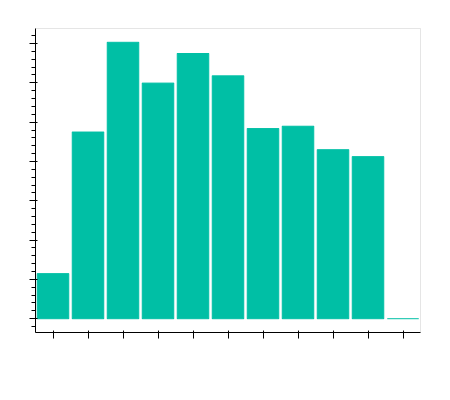

In [3]:
p = vf.plot_bar_chart_distribution(df, 'predicted_probabilities', is_categorical=False, bins=10, plot_width=450, 
                                   plot_height=400)

vf.save_plot(p, 'predicted_probabilities_dis')
display(SVG('../static/images/predicted_probabilities_dis.svg'))


As expected, we can see that the distribution for the loans that were paid back is right skewed while the distribution for loans that defaulted is left skewed. 

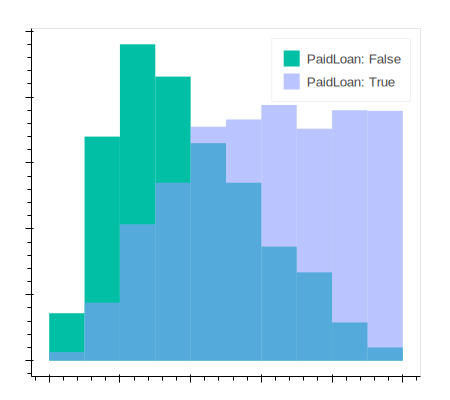

In [4]:
p = vf.plot_multiple_distributions(df, 'Predicted probabilities by loan status', 'predicted_probabilities', 'PaidLoan', plot_width=450, plot_height=400)
vf.save_plot(p, 'predicted_probabilities_dis_by_status')
display(SVG('../static/images/predicted_probabilities_dis_by_status.svg'))

## ROC and AUC

In the figure below, we can see the ROC curve when there is only a common threshold for all groups. The corresponding AUC value is of 0.764.


In [5]:
fpr, tpr, thresholds, auc_score = get_roc_auc_data(df['PaidLoan'], df['predicted_probabilities'])

In [6]:
p = vf.plot_roc_curve(
    {'ROC': {'fpr': fpr, 'tpr': tpr, 'line_colour':'#00BFA5', 'alpha':0.7, 'line_dash':'solid'}},
     title='ROC curve by age group (AUC={:.3f})'.format(auc_score), plot_width=500, plot_height=500)

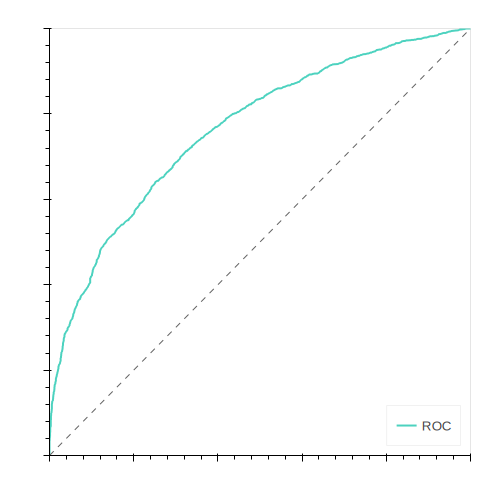

In [7]:
vf.save_plot(p, 'roc_curve')
display(SVG('../static/images/roc_curve.svg'))

# Model performance results based on "Gender"

## Predicted Probabilities

When looking at the distribution of probabilities for male and females, we can notice that the male distribution has a more defined peak around 0.45 while this is less prevalent for the female distribution. 

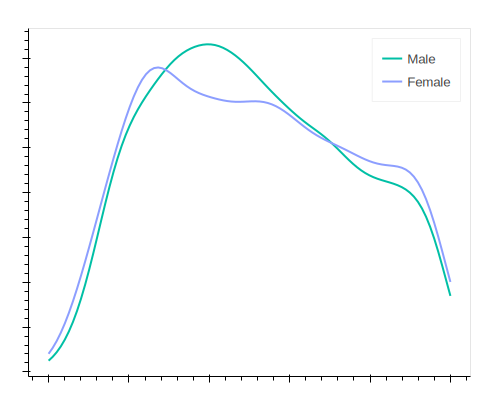

In [8]:
df = df[df['Gender']!='Unknown']
p = vf.plot_density(df, title='Density estimation of predicted probabilities', 
                    column_line_name='predicted_probabilities', column_category_name='Gender', plot_width=500,
                    plot_height=400)

vf.save_plot(p, 'predicted_probabilities_gender')
display(SVG('../static/images/predicted_probabilities_gender.svg'))

As we look at the distribution of probabilities by default status for males and females (see next two graphs), we can notice the following:

- The shared area "PaidLoan" status for males has a more defined peak than the shared area for females. 
- That means that the intersection between both "PaidLoan" distribution for males is more of a sensitive division than for females. 

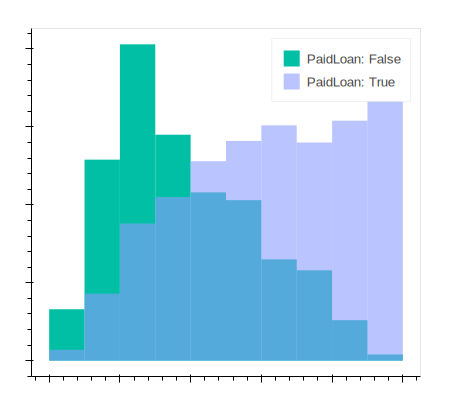

In [9]:
df_fem = df[df['Gender']=='Female']
p = vf.plot_multiple_distributions(df_fem, 'Predicted probabilities for females', 'predicted_probabilities', 'PaidLoan', plot_width=450, plot_height=400)

vf.save_plot(p, 'fem_predicted_probabilities_dis_by_status')
display(SVG('../static/images/fem_predicted_probabilities_dis_by_status.svg'))

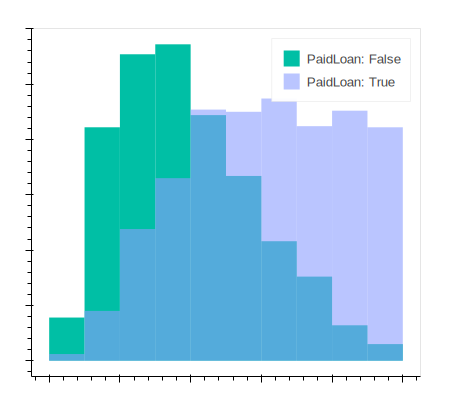

In [10]:
df_male = df[df['Gender']=='Male']
p = vf.plot_multiple_distributions(df_male, 'Predicted probabilities for males', 'predicted_probabilities', 'PaidLoan', plot_width=450, plot_height=400)

vf.save_plot(p, 'male_predicted_probabilities_dis_by_status')
display(SVG('../static/images/male_predicted_probabilities_dis_by_status.svg'))

## ROC and AUC 

We will now look at the ROC curves splitted by each group’s classes. The differences that we will notice among the curves (e.g. male vs female) are due to differences in prediction of TPR and FPR. Lower curves, consequently with lower AUC values, suggests that the predictions are less accurate for those classes.

If we look at ROC curve for gender below, we can notice that the line for females is in most occasions below the curve of males. We can therefore see a slightly lower AUC value of 0.760 for females compared to 0.767 for males. 

In [11]:
test_gender_male, test_gender_fem = split_test_set_by_binary_category(df, 'Gender', ['Male', 'Female'])

fpr_male, tpr_male, thresholds_male =roc_curve(test_gender_male['PaidLoan'], 
                                               test_gender_male['predicted_probabilities'], pos_label=1)
male_auc = auc(fpr_male, tpr_male)

fpr_fem, tpr_fem, thresholds_fem =roc_curve(test_gender_fem['PaidLoan'], 
                                            test_gender_fem['predicted_probabilities'], pos_label=1)
female_auc = auc(fpr_fem, tpr_fem)

In [12]:
p = vf.plot_roc_curve(
    {'male': {'fpr': fpr_male, 'tpr': tpr_male, 'line_colour':'#536dfe', 'alpha':0.7, 'line_dash':'solid'},
     'female': {'fpr': fpr_fem, 'tpr': tpr_fem,'line_colour':'#00BFA5', 'alpha':1.0, 'line_dash':'dashed'}},
     title='ROC curve by age group (AUC [male]={:.3f} | AUC [female]={:.3f})'
                                   .format(male_auc, female_auc), plot_width=500, plot_height=500)

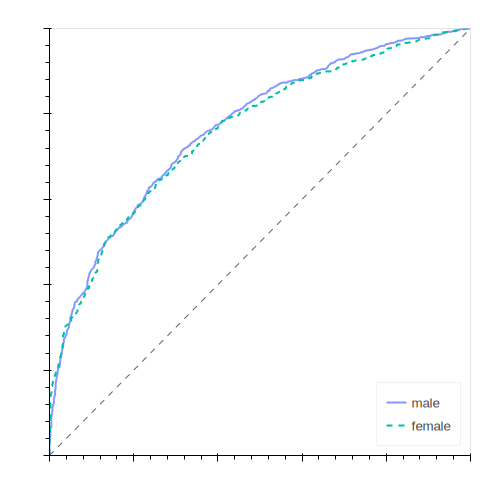

In [13]:
vf.save_plot(p, 'roc_curve_gender')
display(SVG('../static/images/roc_curve_gender.svg'))

# Model performance results based on "Age Group"

## Predicted probabilities

When split the distributions for predicted probabilities by age group, we can notice that the distribution for under 40 is slightly more skewed towards the left. This is expected as the default rate for such group is a bit higher.

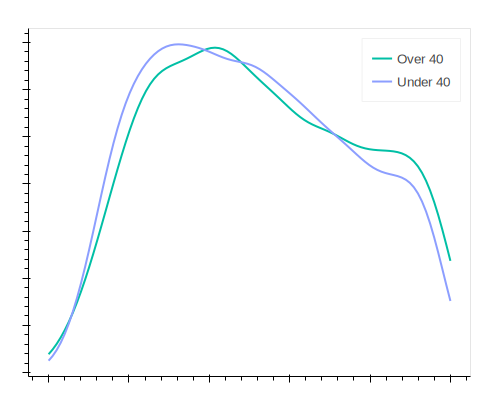

In [14]:
p = vf.plot_density(df, title='Density estimation of predicted probabilities by Age Group', 
                    column_line_name='predicted_probabilities', column_category_name='AgeGroup', plot_width=500,
                    plot_height=400)

vf.save_plot(p, 'predicted_probabilities_age_group')
display(SVG('../static/images/predicted_probabilities_age_group.svg'))

The shared area by "PaidLoan" status for people under 40 is more normally distributed than for people above 40. This may be the thresholds selected for people over 40 a bit more volatile across each algorithmic intervention. 

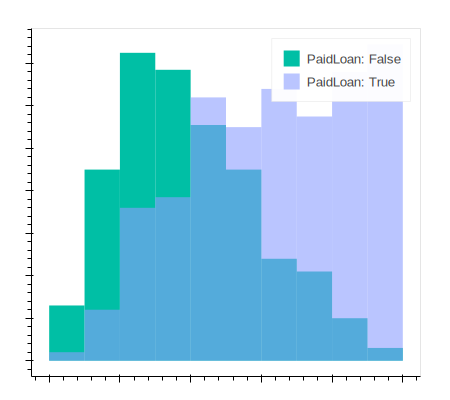

In [15]:
df_over40 = df[df['AgeGroup']=='Over 40']
p = vf.plot_multiple_distributions(df_over40, 'Predicted probabilities for people over 40 years old', 
                                   'predicted_probabilities', 'PaidLoan', plot_width=450, plot_height=400)

vf.save_plot(p, 'over40_predicted_probabilities_dis_by_status')
display(SVG('../static/images/over40_predicted_probabilities_dis_by_status.svg'))

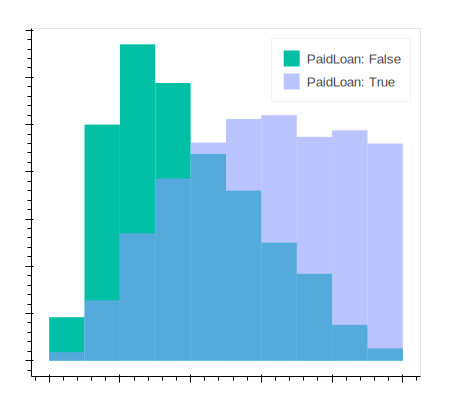

In [16]:
df_under40 = df[df['AgeGroup']=='Under 40']
p = vf.plot_multiple_distributions(df_under40, 'Predicted probabilities for people under 40 years old', 
                                   'predicted_probabilities', 'PaidLoan', plot_width=450, plot_height=400)

vf.save_plot(p, 'under40_predicted_probabilities_dis_by_status')
display(SVG('../static/images/under40_predicted_probabilities_dis_by_status.svg'))

## ROC and AUC

From the ROC graph below, we can see that the line for people over 40 is usually above the line for people under 40. It is important to note that in the Bondora’s loan book the percentage of people under 40 was much higher than the percentage of people above 40. That would mean that alternative features to describe people under 40 may be necessary.

For the discrepancies identified in each group, we may start considering that the set of features used may be more representative for males and/or people over 40 years old. The dataset may be biased towards men, usually older, as it is historically the data that has been more accessible to study and work with. 


In [17]:
test_age_over_40, test_age_under_40 = split_test_set_by_binary_category(df, 'AgeGroup', ['Over 40', 'Under 40'])

fpr_over40, tpr_over40, thresholds_over40 =roc_curve(test_age_over_40['PaidLoan'], 
                                                     test_age_over_40['predicted_probabilities'], pos_label=1)
over40_auc = auc(fpr_over40, tpr_over40)

fpr_under40, tpr_under40, thresholds_under40 =roc_curve(test_age_under_40['PaidLoan'], 
                                                        test_age_under_40['predicted_probabilities'], pos_label=1)
under40_auc = auc(fpr_under40, tpr_under40,)

In [18]:
p = vf.plot_roc_curve(
    {'+ 40 yrs': {'fpr': fpr_over40, 'tpr': tpr_over40, 'line_colour':'#536dfe', 'alpha':0.7, 'line_dash':'solid'},
     '< 40 yrs': {'fpr': fpr_under40, 'tpr': tpr_under40,'line_colour':'#00BFA5', 'alpha':1.0, 'line_dash':'dashed'}},
     title='ROC curve by age group (AUC [+40 yrs]={:.3f} | AUC [<40 yrs]={:.3f})'
                                   .format(over40_auc, under40_auc), plot_width=500, plot_height=500)

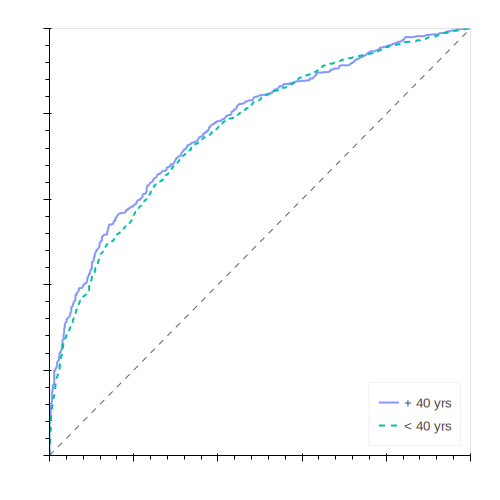

In [19]:
vf.save_plot(p, 'roc_curve_age_group')
display(SVG('../static/images/roc_curve_age_group.svg'))